Libraries

In [122]:
import tensorflow as tf #model
import numpy as np #calculations
import matplotlib.pyplot as plt #for plots
import pandas as pd #for reading and processing data
from tensorflow.keras.layers import Normalization #for getting the mean and std
from tensorflow.keras.layers import InputLayer, Dense  #for the input size and hidden layers
from tensorflow.keras.losses import MeanSquaredError #for calculating model accuracy
from tensorflow.keras.optimizers import Adam #for optimization
from tensorflow.keras.metrics import RootMeanSquaredError #for calculating model performance

Reading in the data

In [123]:
heartrisk_data = pd.read_csv("heartRisk.csv", ",")

<ipython-input-123-7fc6a8835490>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  heartrisk_data = pd.read_csv("heartRisk.csv", ",")


Convert the csv into tensorflow

In [124]:
heartrisk_tf = tf.constant(heartrisk_data)

Shuffle to minimize bias

In [125]:
heartrisk_tf = tf.random.shuffle(heartrisk_tf)

Separate inputs from outputs

In [126]:
input = heartrisk_tf[:,0:-1]
print(input.shape)

(1000, 9)


In [127]:
output = heartrisk_tf[:,-1]
output = tf.expand_dims(output, axis = -1) #into 2D
print(output.shape)

(1000, 1)


Normalization

In [128]:
#Determing train, test, validation, and dataset size ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
dataset_size = len(input)

In [129]:
#Getting the rows and columns for the input training dataset
input_train = input[:int(dataset_size * train_ratio)]
output_train = output[:int(dataset_size * train_ratio)]
print(input_train.shape, output_train.shape)

(800, 9) (800, 1)


In [130]:
#Efficient way for loading and processing data
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
train_dataset = train_dataset.shuffle(buffer_size=9, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [131]:
#Getting the rows and columns for the validation dataset
input_val = input[int(dataset_size * train_ratio):int(dataset_size *( train_ratio + val_ratio))]
output_val = output[int(dataset_size * train_ratio):int(dataset_size *( train_ratio + val_ratio))]
print(input_val.shape, output_val.shape)

(100, 9) (100, 1)


In [132]:
#Efficient way for loading and processing validation data
val_dataset = tf.data.Dataset.from_tensor_slices((input_val, output_val))
val_dataset = val_dataset.shuffle(buffer_size=9, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [133]:
#Getting the rows and columns for the test dataset
input_test = input[int(dataset_size *( train_ratio + val_ratio)):]
output_test = output[int(dataset_size *( train_ratio + val_ratio)):]
print(input_test.shape, output_test.shape)

(100, 9) (100, 1)


In [134]:
#Efficient way for loading and processing test data
test_dataset = tf.data.Dataset.from_tensor_slices((input_test, output_test))
test_dataset = test_dataset.shuffle(buffer_size=9, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [135]:
#using the normalization function for calculating mean and std for each column in our dataset
normalizer = Normalization()
normalizer.adapt(input_train)
normalizer(input)

<tf.Tensor: shape=(1000, 9), dtype=float32, numpy=
array([[-0.97530484,  0.9369814 , -1.0100505 , ...,  0.04014786,
        -1.3140231 , -1.2995462 ],
       [ 1.0253206 , -1.067257  ,  0.99004954, ...,  0.32298735,
         0.8495884 , -0.42076737],
       [-0.97530484, -1.067257  ,  0.99004954, ..., -0.71409076,
         0.35785848, -1.1321598 ],
       ...,
       [ 1.0253206 , -1.067257  ,  0.99004954, ..., -1.1540633 ,
        -0.9206392 ,  0.41616488],
       [-0.97530484,  0.9369814 ,  0.99004954, ...,  0.1658543 ,
        -1.461542  ,  0.8764776 ],
       [ 1.0253206 , -1.067257  ,  0.99004954, ..., -0.65123755,
        -1.609061  , -0.04414787]], dtype=float32)>

Building the model

In [136]:
#the model using Sequential API and its layers
hr_model = tf.keras.Sequential([
                                InputLayer(input_shape=(9,)),
                                normalizer,
                                Dense(128, activation = "relu"),
                                Dense(128, activation = "relu"),
                                Dense(128, activation = "relu"),
                                Dense(1),
])
hr_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_27 (Dense)            (None, 128)               1280      
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34,452
Trainable params: 34,433
Non-trainable params: 19
_________________________________________________

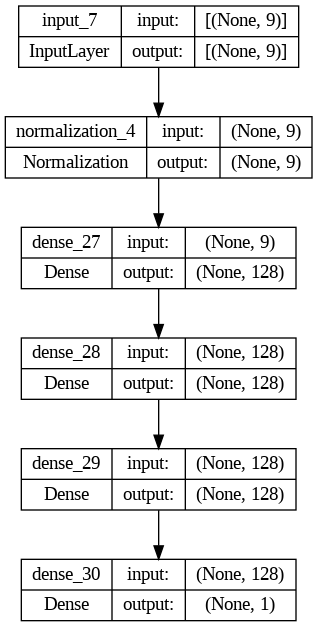

In [137]:
#viewing the model architecture
tf.keras.utils.plot_model(hr_model, to_file="hr_model.png", show_shapes=True)

Error Measurement and Sanctioning: Loss Function

In [138]:
#calculating the loss function
hr_model.compile(optimizer = Adam(learning_rate = 0.1),
                 loss = MeanSquaredError(),
                 metrics = RootMeanSquaredError()
                 )

Training and optimization

In [ ]:
#training the model and conducting validation at the same time
hr_model_training = hr_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Plot

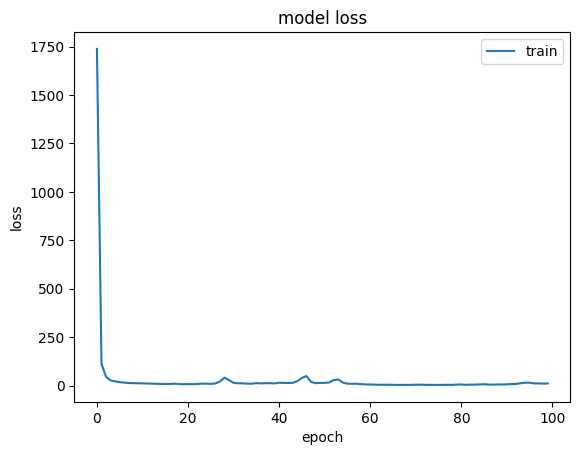

In [140]:
#plot for seeing the loss
plt.plot(hr_model_training.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show( )

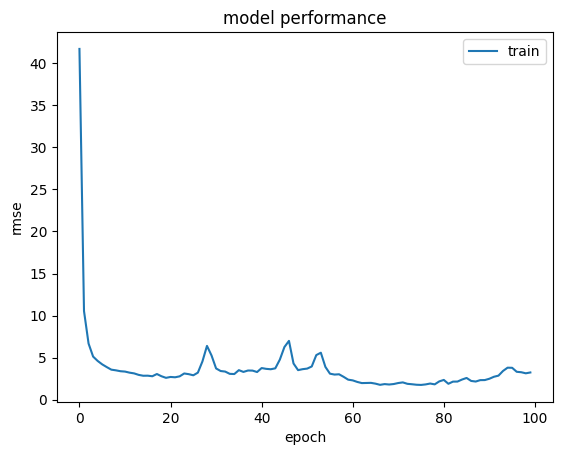

In [141]:
#plot for RMSE
plt.plot(hr_model_training.history['root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show( )

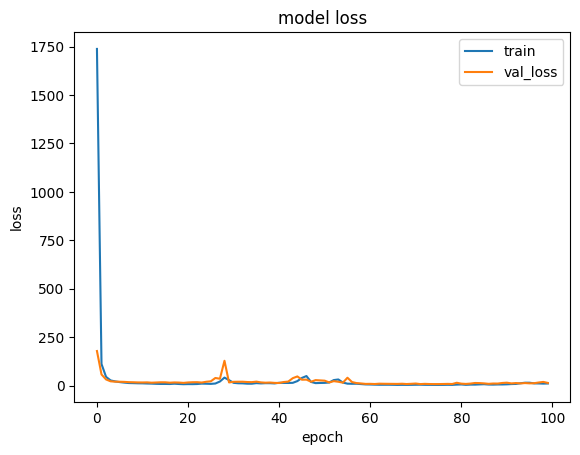

In [142]:
#Compairing the validation loss and the training data
plt.plot(hr_model_training.history['loss'])
plt.plot(hr_model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show( )

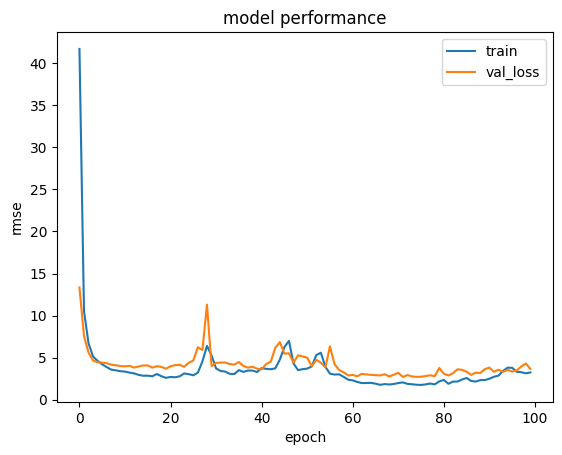

In [143]:
#more comparisons
plt.plot(hr_model_training.history['root_mean_squared_error'])
plt.plot(hr_model_training.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show( )

Evaluation

In [144]:
#getting the prediction
output_pred = list(hr_model.predict(input_test)[:,0])

4/4 [==============================] - 0s 3ms/step


In [145]:
#getting the actual values
output_actual = list((output_test)[:,0].numpy())

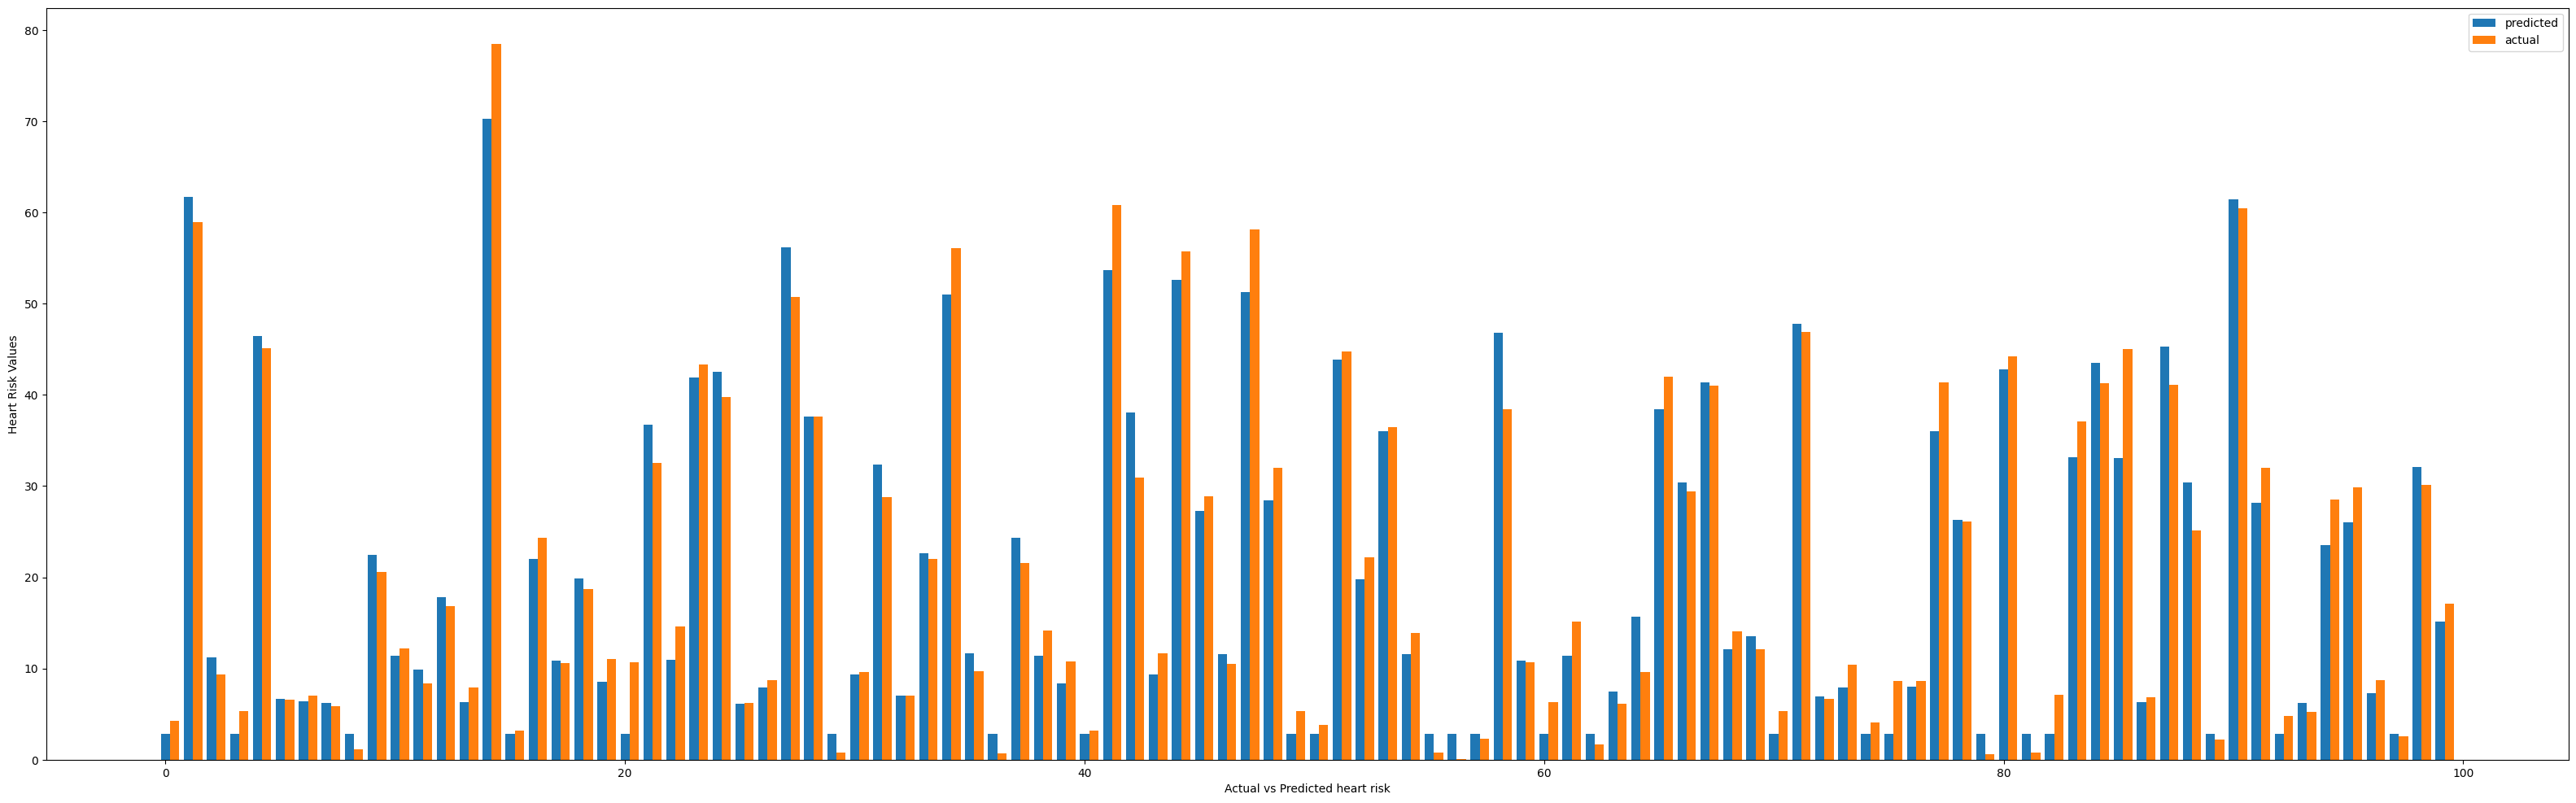

In [146]:
##plot to compare the actual and predicted values
ind = np.arange(100) #for getting position of each element
plt.figure(figsize=(40,12))

width = 0.4

plt.bar(ind, output_pred, width, label='Predicted heart risk')
plt.bar(ind + width, output_actual, width, label='Actual heart risk')

plt.xlabel('Actual vs Predicted heart risk')
plt.ylabel('Heart Risk Values')

plt.legend(['predicted', 'actual'])

plt.show()